# **Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19**
# **Проект по дисциплине «Инфраструктура Big Data»**

# **1. Подготовка среды**

In [1]:
# Установка PySpark в Google Colab
!pip install pyspark

In [2]:
# Импорт необходимых библиотек
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, avg, sum, round, row_number, date_format, to_date
from pyspark.sql.types import IntegerType, DateType, StringType
from pyspark.sql.window import Window
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [3]:
# Инициализация Spark-сессии
spark = SparkSession.builder \
    .appName("COVID19_XRay_Analysis") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print("Spark сессия успешно запущена")
print(f"Версия Spark: {spark.version}")
print(spark)

Spark сессия успешно запущена
Версия Spark: 4.0.1


Среда подготовлена, Spark-сессия запущена.

# **2. Загрузка данных**

In [4]:
# Скачиваем датасет
!wget -O metadata.csv https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv

--2025-12-28 16:25:34--  https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599143 (585K) [text/plain]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>] 585.10K  --.-KB/s    in 0.04s   

2025-12-28 16:25:34 (14.1 MB/s) - ‘metadata.csv’ saved [599143/599143]



In [5]:
# Чтение CSV файла
df = spark.read.option("header", "true").csv("metadata.csv")

In [6]:
# Проверка структуры данных
print("Схема данных:")
df.printSchema()

print("\nПервые 5 строк данных:")
df.show(5, truncate=False)

print(f"\nОбщее количество записей: {df.count()}")
print(f"Количество колонок: {len(df.columns)}")

Схема данных:
root
 |-- patientid: string (nullable = true)
 |-- offset: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: string (nullable = true)
 |-- pO2_saturation: string (nullable = true)
 |-- leukocyte_count: string (nullable = true)
 |-- neutrophil_count: string (nullable = true)
 |-- lymphocyte_count: string (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: strin

In [7]:
# Выбираем только необходимые колонки согласно заданию
required_columns = ["patientid", "age", "sex", "finding", "view", "date"]
df = df.select(required_columns)

Импортировали датасет прямо в Colab, выбрали необходимые колонки, с которыми будем работать дальше.

# **3. Предобработка данных**

In [8]:
# 3.1. Анализ пропущенных значений
print("\n1. Анализ пропущенных значений:")

for column in required_columns:
    null_count = df.filter(col(column).isNull()).count()
    total_count = df.count()
    percentage = (null_count / total_count) * 100 if total_count > 0 else 0
    print(f"{column}: {null_count} пропусков ({percentage:.1f}%)")


1. Анализ пропущенных значений:
patientid: 0 пропусков (0.0%)
age: 237 пропусков (24.9%)
sex: 80 пропусков (8.4%)
finding: 0 пропусков (0.0%)
view: 0 пропусков (0.0%)
date: 289 пропусков (30.4%)


In [9]:
# 3.2. Заполнение пропусков
print("\n2. Заполнение пропущенных значений:")

# Заполняем пропуски в возрасте медианным значением
valid_ages = df.filter((col("age").isNotNull()) & (col("age") != ""))
median_age = 50  # значение по умолчанию
if valid_ages.count() > 0:
    # Преобразуем возраст в числовой формат и вычисляем медиану
    try:
        age_values = valid_ages.select(col("age").cast("int")).filter(col("age").between(0, 120)).collect()
        if age_values:
            median_age = sorted([int(row[0]) for row in age_values if row[0] is not None])[len(age_values)//2]
    except:
        pass

print(f"Медианный возраст для заполнения пропусков: {median_age}")

# Заполняем пропуски
df = df.withColumn(
    "age_processed",
    when((col("age").isNull()) | (col("age") == ""), median_age)
    .otherwise(col("age").cast(IntegerType()))
)

# Приводим возраст к целому числу
df = df.withColumn("age_processed", col("age_processed").cast(IntegerType()))

# Заполняем пропуски в поле пола наиболее частым значением
most_common_sex = df.filter(col("sex").isNotNull() & (col("sex") != "")) \
    .groupBy("sex") \
    .agg(count("*").alias("cnt")) \
    .orderBy(col("cnt").desc()) \
    .first()

most_common_sex_value = most_common_sex["sex"] if most_common_sex else "UNKNOWN"
print(f"Наиболее частый пол: {most_common_sex_value}")

df = df.withColumn(
    "sex_processed",
    when((col("sex").isNull()) | (col("sex") == ""), most_common_sex_value)
    .otherwise(col("sex"))
)


2. Заполнение пропущенных значений:
Медианный возраст для заполнения пропусков: 54
Наиболее частый пол: M


In [10]:
# 3.3. Унификация диагнозов
print("\n3. Унификация диагнозов:")

def unify_finding(finding):
    if finding is None:
        return "Unknown"

    finding_lower = str(finding).lower()

    if "covid" in finding_lower:
        return "COVID-19"
    elif "pneumonia" in finding_lower:
        return "Pneumonia"
    elif "normal" in finding_lower or "no finding" in finding_lower:
        return "Normal"
    elif "todo" in finding_lower:
        return "Unknown"
    else:
        return "Other"

from pyspark.sql.functions import udf
unify_finding_udf = udf(unify_finding, StringType())

df = df.withColumn("finding_unified", unify_finding_udf(col("finding")))

print("Унифицированные диагнозы:")
df.groupBy("finding_unified").agg(count("*").alias("count")).orderBy(col("count").desc()).show()


3. Унификация диагнозов:
Унифицированные диагнозы:
+---------------+-----+
|finding_unified|count|
+---------------+-----+
|       COVID-19|  584|
|      Pneumonia|  242|
|        Unknown|   83|
|         Normal|   22|
|          Other|   19|
+---------------+-----+



In [11]:
# 3.4. Обработка даты
print("\n4. Обработка даты исследований:")

def parse_date(date_str):
    if date_str is None:
        return None

    date_str = str(date_str).strip()

    # Удаляем лишние пробелы
    date_str = re.sub(r'\s+', ' ', date_str)

    # Пробуем разные форматы
    formats = [
        '%B %d, %Y',      # January 22, 2020
        '%b %d, %Y',      # Jan 22, 2020
        '%d %B %Y',       # 12 March 2020
        '%m/%d/%Y',       # 3/3/2020
        '%m/%d/%y',       # 03/09/20
        '%Y-%m-%d',       # 2020-01-22
        '%Y',             # 2020 (только год)
        '%B %Y',          # March 2020
        '%B %d',          # January 22 (без года)
        '%b %d',          # Jan 22 (без года)
        '%m/%d',          # 1/22 (без года)
    ]

    for fmt in formats:
        try:
            # Для форматов без года добавляем текущий год
            if fmt in ['%B %d', '%b %d', '%m/%d']:
                date_str_with_year = f"{date_str}, 2020"
                fmt_with_year = fmt + ", %Y"
                return datetime.strptime(date_str_with_year, fmt_with_year).date()
            elif fmt == '%Y':
                # Если только год, используем 1 января этого года
                return datetime.strptime(date_str, fmt).date().replace(month=1, day=1)
            elif fmt == '%B %Y':
                # Если месяц и год, используем 1 число
                return datetime.strptime(date_str, fmt).date().replace(day=1)
            else:
                return datetime.strptime(date_str, fmt).date()
        except ValueError:
            continue

    # Если ни один формат не подошел
    return None

parse_date_udf = udf(parse_date, DateType())
df = df.withColumn("date_parsed", parse_date_udf(col("date")))


4. Обработка даты исследований:


In [12]:
# 3.5. Обработка проекций снимков
print("\n5. Стандартизация проекций снимков:")

def standardize_view(view):
    if view is None:
        return "Unknown"

    view_upper = str(view).upper()

    if "PA" in view_upper:
        return "PA"
    elif "AP" in view_upper:
        return "AP"
    elif "LATERAL" in view_upper:
        return "Lateral"
    else:
        return "Other"

standardize_view_udf = udf(standardize_view, StringType())
df = df.withColumn("view_standardized", standardize_view_udf(col("view")))


5. Стандартизация проекций снимков:


In [13]:
# 3.6. Удаление дубликатов
print("\n6. Удаление дубликатов:")

initial_count = df.count()
df = df.dropDuplicates(["patientid", "age_processed", "sex_processed", "finding_unified", "view_standardized", "date_parsed"])
final_count = df.count()

print(f"Записей до удаления дубликатов: {initial_count}")
print(f"Записей после удаления дубликатов: {final_count}")
print(f"Удалено дубликатов: {initial_count - final_count}")


6. Удаление дубликатов:
Записей до удаления дубликатов: 950
Записей после удаления дубликатов: 641
Удалено дубликатов: 309


Заполнены пропуски в возрасте и поле. Так же приведены к единому формату (насколько возможно) дата исследования и проекции снимков. Так же удалены дубликаты.

# **4. Анализ качества данных**

In [14]:
# 4.1. Распределение пропущенных значений после обработки
print("\n1. Распределение пропущенных значений после обработки:")

processed_columns = ["age_processed", "sex_processed", "finding_unified", "view_standardized", "date_parsed"]
for column in processed_columns:
    null_count = df.filter(col(column).isNull()).count()
    total_count = df.count()
    percentage = (null_count / total_count) * 100 if total_count > 0 else 0
    print(f"{column}: {null_count} пропусков ({percentage:.1f}%)")


1. Распределение пропущенных значений после обработки:
age_processed: 0 пропусков (0.0%)
sex_processed: 0 пропусков (0.0%)
finding_unified: 0 пропусков (0.0%)
view_standardized: 0 пропусков (0.0%)
date_parsed: 192 пропусков (30.0%)


In [15]:
# 4.2. Выявление аномальных значений
print("\n2. Выявление аномальных значений:")

# Аномалии в возрасте
print("Аномалии в возрасте:")
df.filter((col("age_processed") < 0) | (col("age_processed") > 120)).select("age_processed").distinct().show()

# Статистика по возрасту
print("Статистика по возрасту:")
df.select("age_processed").summary().show()


2. Выявление аномальных значений:
Аномалии в возрасте:
+-------------+
|age_processed|
+-------------+
+-------------+

Статистика по возрасту:
+-------+------------------+
|summary|     age_processed|
+-------+------------------+
|  count|               641|
|   mean| 53.62558502340094|
| stddev|15.065593064455692|
|    min|                18|
|    25%|                45|
|    50%|                54|
|    75%|                64|
|    max|                94|
+-------+------------------+



По итогам предобработки данных были решены проблемы пропусков и дублирования. Оставшиеся пропуски в датах - изначально пустые поля. Оставим их для полноты данных, потому что они, не смотря на отсутствие временной метки, статистически важны. Аномалий в данных не обнаружено.

# **5. SQL-аналитика**

In [16]:
# Создаем временное представление для SQL запросов
df.createOrReplaceTempView("covid_data")

In [17]:
# 5.1. Запрос 1: Базовая статистика по диагнозам
print("\n1. Базовая статистика по диагнозам:")

query1 = """
SELECT
    finding_unified as diagnosis,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM covid_data), 2) as percentage
FROM covid_data
GROUP BY finding_unified
ORDER BY count DESC
"""

result1 = spark.sql(query1)
result1.show()


1. Базовая статистика по диагнозам:
+---------+-----+----------+
|diagnosis|count|percentage|
+---------+-----+----------+
| COVID-19|  412|     64.27|
|Pneumonia|  164|     25.59|
|  Unknown|   27|      4.21|
|   Normal|   20|      3.12|
|    Other|   18|      2.81|
+---------+-----+----------+



In [18]:
# 5.2. Запрос 2: Распределение по полу и диагнозам
print("\n2. Распределение по полу и диагнозам:")

query2 = """
SELECT
    sex_processed as sex,
    finding_unified as diagnosis,
    COUNT(*) as count
FROM covid_data
GROUP BY sex_processed, finding_unified
ORDER BY sex, count DESC
"""

result2 = spark.sql(query2)
result2.show()


2. Распределение по полу и диагнозам:
+---+---------+-----+
|sex|diagnosis|count|
+---+---------+-----+
|  F| COVID-19|  124|
|  F|Pneumonia|   59|
|  F|   Normal|    9|
|  F|  Unknown|    6|
|  F|    Other|    5|
|  M| COVID-19|  288|
|  M|Pneumonia|  105|
|  M|  Unknown|   21|
|  M|    Other|   13|
|  M|   Normal|   11|
+---+---------+-----+



In [19]:
# 5.3. Запрос 3: Оконная функция (топ-3 по возрасту в каждой группе диагнозов)
print("\n3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов):")

query3 = """
SELECT
    diagnosis,
    age,
    patientid,
    sex,
    rank
FROM (
    SELECT
        finding_unified as diagnosis,
        age_processed as age,
        patientid,
        sex_processed as sex,
        ROW_NUMBER() OVER (PARTITION BY finding_unified ORDER BY age_processed DESC) as rank
    FROM covid_data
    WHERE age_processed IS NOT NULL
) ranked
WHERE rank <= 3
ORDER BY diagnosis, rank
"""

result3 = spark.sql(query3)
result3.show()


3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов):
+---------+---+---------+---+----+
|diagnosis|age|patientid|sex|rank|
+---------+---+---------+---+----+
| COVID-19| 94|     326b|  M|   1|
| COVID-19| 93|     324b|  F|   2|
| COVID-19| 88|      200|  M|   3|
|   Normal| 78|      325|  F|   1|
|   Normal| 78|      315|  F|   2|
|   Normal| 75|     313b|  M|   3|
|    Other| 78|      421|  M|   1|
|    Other| 70|      453|  M|   2|
|    Other| 58|      456|  M|   3|
|Pneumonia| 90|      460|  M|   1|
|Pneumonia| 90|      460|  M|   2|
|Pneumonia| 80|       91|  F|   3|
|  Unknown| 54|      384|  M|   1|
|  Unknown| 54|      387|  M|   2|
|  Unknown| 54|      388|  M|   3|
+---------+---+---------+---+----+



In [20]:
# 5.4. Запрос 4: Анализ временных трендов по датам исследований
print("\n4. Анализ временных трендов по датам исследований:")

query4 = """
SELECT
    DATE_FORMAT(date_parsed, 'yyyy-MM') as month,
    COUNT(*) as studies_count,
    finding_unified as diagnosis
FROM covid_data
WHERE date_parsed IS NOT NULL
GROUP BY DATE_FORMAT(date_parsed, 'yyyy-MM'), finding_unified
ORDER BY month, studies_count DESC
"""

result4 = spark.sql(query4)
result4.show(20)


4. Анализ временных трендов по датам исследований:
+-------+-------------+---------+
|  month|studies_count|diagnosis|
+-------+-------------+---------+
|2003-03|            3|Pneumonia|
|2004-01|            5|Pneumonia|
|2007-01|            1|Pneumonia|
|2009-09|            3|Pneumonia|
|2010-01|            3|Pneumonia|
|2010-05|            2|Pneumonia|
|2010-10|            1|Pneumonia|
|2011-01|            3|Pneumonia|
|2013-01|            5|Pneumonia|
|2014-01|            6|Pneumonia|
|2015-01|           11|Pneumonia|
|2015-05|            1|Pneumonia|
|2016-01|           14|Pneumonia|
|2017-01|            3|Pneumonia|
|2017-06|            1|Pneumonia|
|2018-01|            3|Pneumonia|
|2019-01|            2|   Normal|
|2019-02|            1|Pneumonia|
|2019-05|            1|Pneumonia|
|2019-11|            1|Pneumonia|
+-------+-------------+---------+
only showing top 20 rows


In [21]:
# 5.5. Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
print("\n5. Статистика по проекциям снимков и их связи с диагнозами:")

query5 = """
SELECT
    view_standardized as view_type,
    finding_unified as diagnosis,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view_standardized), 2) as percentage_in_view
FROM covid_data
WHERE view_standardized IS NOT NULL AND view_standardized != 'Unknown'
GROUP BY view_standardized, finding_unified
ORDER BY view_type, count DESC
"""

result5 = spark.sql(query5)
result5.show()


5. Статистика по проекциям снимков и их связи с диагнозами:
+---------+---------+-----+------------------+
|view_type|diagnosis|count|percentage_in_view|
+---------+---------+-----+------------------+
|       AP| COVID-19|  189|             71.32|
|       AP|Pneumonia|   49|             18.49|
|       AP|  Unknown|   17|              6.42|
|       AP|   Normal|    7|              2.64|
|       AP|    Other|    3|              1.13|
|    Other| COVID-19|   67|             58.26|
|    Other|Pneumonia|   39|             33.91|
|    Other|    Other|    6|              5.22|
|    Other|   Normal|    3|              2.61|
|       PA| COVID-19|  156|             59.77|
|       PA|Pneumonia|   76|             29.12|
|       PA|  Unknown|   10|              3.83|
|       PA|   Normal|   10|              3.83|
|       PA|    Other|    9|              3.45|
+---------+---------+-----+------------------+



# **6. Обработка в PySpark**

In [22]:
# 6.1. Использование UDF
print("\n1. Реализация пользовательских функций (UDF):")

# UDF для категоризации возраста
def categorize_age(age):
    if age is None:
        return "Неизвестно"
    elif age <= 20:
        return "0-20"
    elif age <= 35:
        return "21-35"
    elif age <= 50:
        return "36-50"
    elif age <= 65:
        return "51-65"
    else:
        return "65+"

categorize_age_udf = udf(categorize_age, StringType())

# UDF для расширенной унификации диагнозов
def unify_diagnosis_extended(finding):
    if finding is None:
        return "Unknown"

    finding_lower = str(finding).lower()

    if "covid" in finding_lower and "19" in finding_lower:
        return "COVID-19"
    elif "covid" in finding_lower:
        return "COVID"
    elif "pneumonia" in finding_lower:
        if "bacterial" in finding_lower:
            return "Bacterial Pneumonia"
        elif "viral" in finding_lower:
            return "Viral Pneumonia"
        else:
            return "Pneumonia"
    elif "normal" in finding_lower or "no finding" in finding_lower:
        return "Normal"
    else:
        return "Other"

unify_diagnosis_extended_udf = udf(unify_diagnosis_extended, StringType())

# Применение UDF
print("Применение UDF для категоризации возраста:")
df = df.withColumn("age_category", categorize_age_udf(col("age_processed")))
df.select("age_processed", "age_category").show(10)

print("\nПрименение UDF для расширенной унификации диагнозов:")
df = df.withColumn("diagnosis_extended", unify_diagnosis_extended_udf(col("finding")))
df.select("finding", "diagnosis_extended").show(10)


1. Реализация пользовательских функций (UDF):
Применение UDF для категоризации возраста:
+-------------+------------+
|age_processed|age_category|
+-------------+------------+
|           65|       51-65|
|           52|       51-65|
|           29|       21-35|
|           35|       21-35|
|           54|       51-65|
|           54|       51-65|
|           54|       51-65|
|           54|       51-65|
|           53|       51-65|
|           55|       51-65|
+-------------+------------+
only showing top 10 rows

Применение UDF для расширенной унификации диагнозов:
+--------------------+-------------------+
|             finding| diagnosis_extended|
+--------------------+-------------------+
|        Tuberculosis|              Other|
|Pneumonia/Fungal/...|          Pneumonia|
|Pneumonia/Bacteri...|Bacterial Pneumonia|
|          No Finding|             Normal|
|           Pneumonia|          Pneumonia|
|Pneumonia/Viral/C...|           COVID-19|
|           Pneumonia|          Pneumo

In [23]:
# 6.2. Фильтрация данных
print("\n2. Фильтрация данных по заданным критериям:")

# Фильтруем данные по COVID-19 диагнозу
df_covid = df.filter(col("finding_unified") == "COVID-19")
print(f"Количество записей с COVID-19: {df_covid.count()}")

# Фильтруем данные по определенной возрастной группе
df_adults = df.filter((col("age_processed") >= 18) & (col("age_processed") <= 65))
print(f"Количество записей взрослых пациентов (18-65 лет): {df_adults.count()}")

# Фильтруем данные по конкретной проекции снимка
df_pa_view = df.filter(col("view_standardized") == "PA")
print(f"Количество записей с проекцией PA: {df_pa_view.count()}")


2. Фильтрация данных по заданным критериям:
Количество записей с COVID-19: 412
Количество записей взрослых пациентов (18-65 лет): 503
Количество записей с проекцией PA: 261


In [24]:
# 6.3. Сохранение результатов
print("\n3. Сохранение результатов в оптимизированном формате:")

# Сохраняем все обработанные данные
df.write.mode("overwrite").parquet("covid_xray_processed_full.parquet")
print("Полные обработанные данные сохранены в 'covid_xray_processed_full.parquet'")

# Сохраняем данные по COVID-19 отдельно
df_covid.write.mode("overwrite").parquet("covid_xray_covid_only.parquet")
print("Данные по COVID-19 сохранены в 'covid_xray_covid_only.parquet'")


3. Сохранение результатов в оптимизированном формате:
Полные обработанные данные сохранены в 'covid_xray_processed_full.parquet'
Данные по COVID-19 сохранены в 'covid_xray_covid_only.parquet'


# **7. Визуализация**


1. Круговая диаграмма распределения диагнозов:


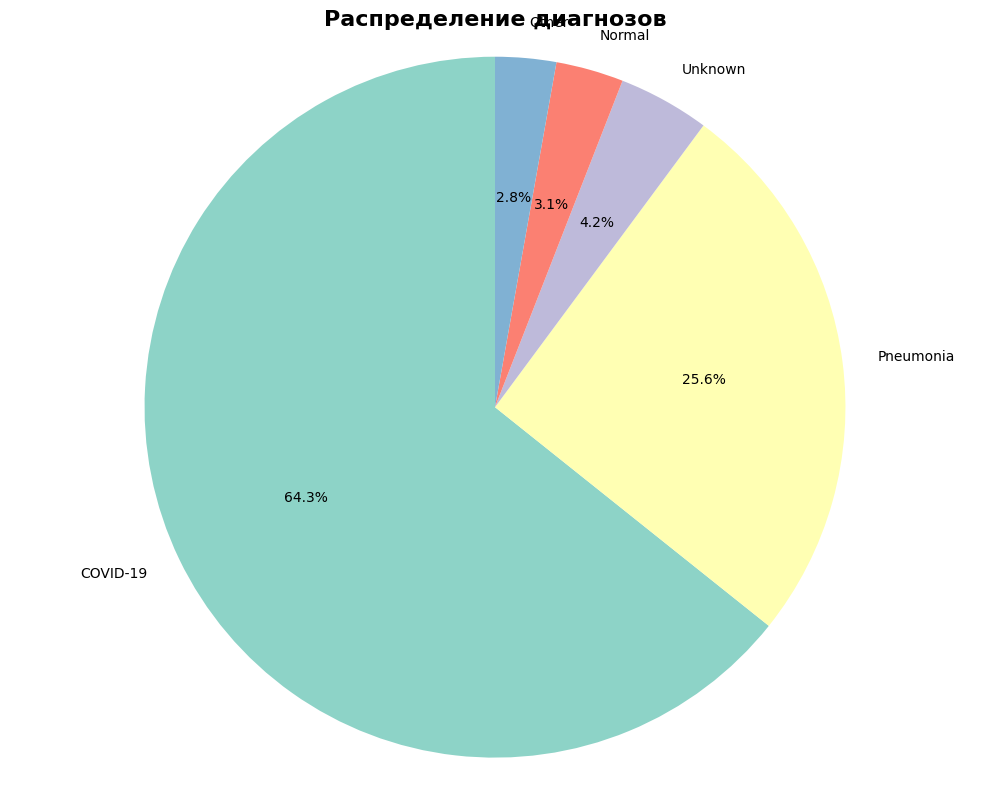

In [25]:
# 7.1. Круговая диаграмма распределения диагнозов
print("\n1. Круговая диаграмма распределения диагнозов:")

diagnosis_distribution = df.groupBy("finding_unified") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc()) \
    .toPandas()

plt.figure(figsize=(10, 8))
plt.pie(diagnosis_distribution['count'],
        labels=diagnosis_distribution['finding_unified'],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Set3.colors)
plt.title('Распределение диагнозов', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Как видно по графику, COVID-19 и Пневмония - самые распространенные заболевания в датасете.


2. Столбчатая диаграмма по возрастным группам:


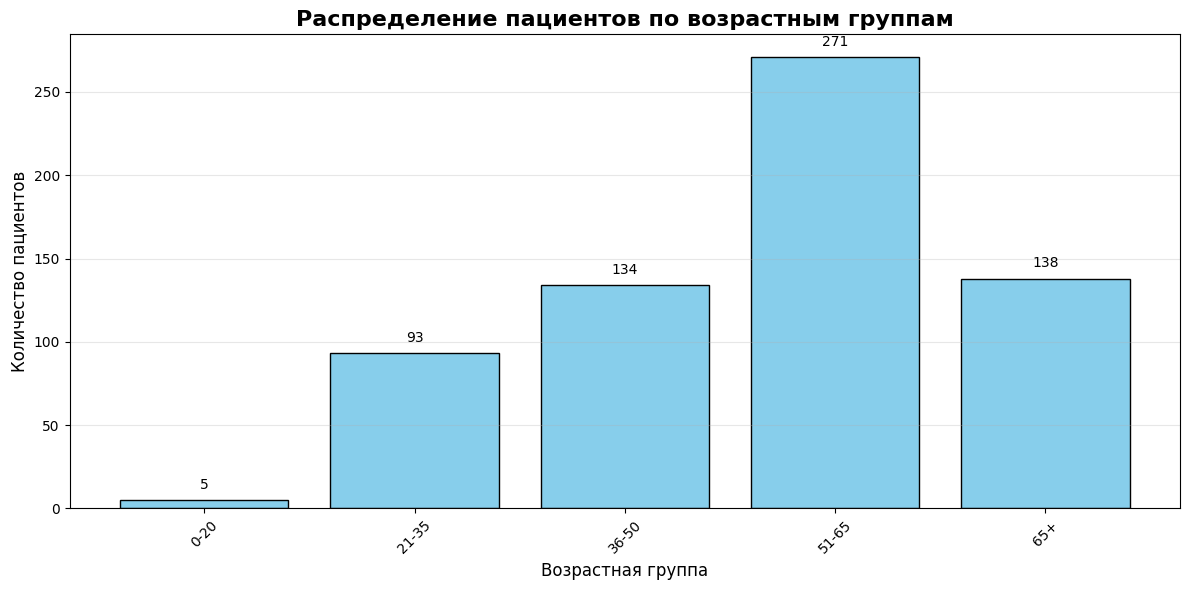

In [26]:
# 7.2. Столбчатая диаграмма по возрастным группам
print("\n2. Столбчатая диаграмма по возрастным группам:")

age_distribution = df.groupBy("age_category") \
    .agg(count("*").alias("count")) \
    .orderBy("age_category") \
    .toPandas()

plt.figure(figsize=(12, 6))
bars = plt.bar(age_distribution['age_category'], age_distribution['count'],
               color='skyblue', edgecolor='black')

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Распределение пациентов по возрастным группам', fontsize=16, fontweight='bold')
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Наиболее многочисленная группа заболевших в возрасте от 51 до 65.


3. График временных трендов исследований:


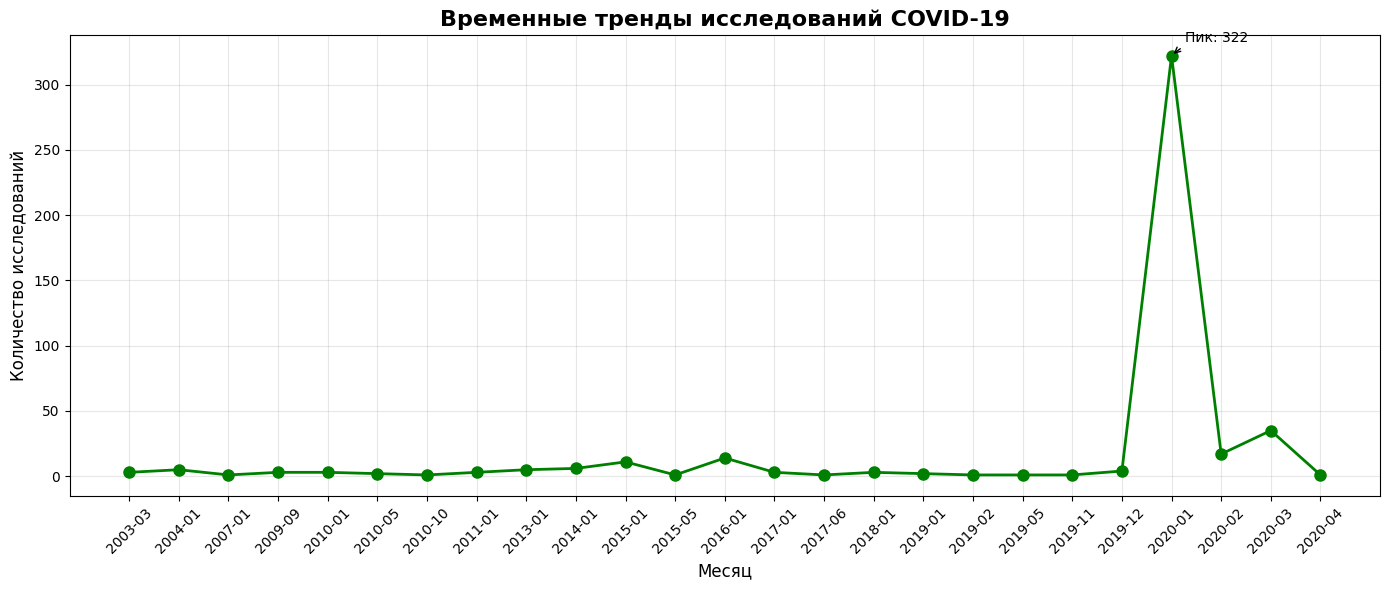

In [27]:
# 7.3. График временных трендов исследований
print("\n3. График временных трендов исследований:")

# Готовим данные для временного тренда
time_trend = df.filter(col("date_parsed").isNotNull()) \
    .groupBy(date_format(col("date_parsed"), "yyyy-MM").alias("month")) \
    .agg(count("*").alias("studies_count")) \
    .orderBy("month") \
    .toPandas()

plt.figure(figsize=(14, 6))
plt.plot(time_trend['month'], time_trend['studies_count'],
         marker='o', linewidth=2, markersize=8, color='green')

plt.title('Временные тренды исследований COVID-19', fontsize=16, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество исследований', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем аннотацию максимального значения
max_idx = time_trend['studies_count'].idxmax()
plt.annotate(f'Пик: {time_trend.iloc[max_idx]["studies_count"]}',
             xy=(time_trend.iloc[max_idx]["month"], time_trend.iloc[max_idx]["studies_count"]),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

Видим явный скачок исследований в 2020 году.


4. Heatmap распределения диагнозов по проекциям снимков:


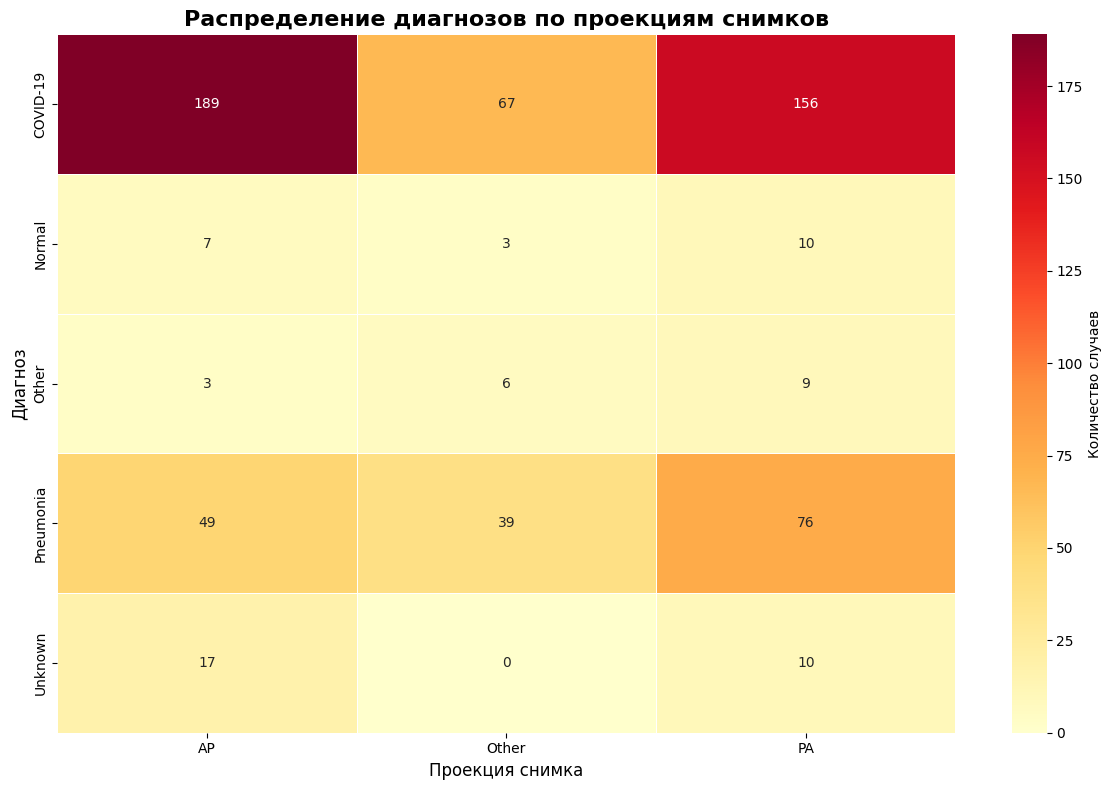

In [28]:
# 7.4. Heatmap распределения диагнозов по проекциям снимков
print("\n4. Heatmap распределения диагнозов по проекциям снимков:")

# Готовим данные для heatmap
heatmap_data = df.filter(col("view_standardized") != "Unknown") \
    .groupBy("view_standardized", "finding_unified") \
    .agg(count("*").alias("count")) \
    .orderBy("view_standardized", "finding_unified") \
    .toPandas()

# Преобразуем в матрицу для heatmap
pivot_table = heatmap_data.pivot(index="finding_unified",
                                 columns="view_standardized",
                                 values="count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlOrRd',
            linewidths=.5, cbar_kws={'label': 'Количество случаев'})

plt.title('Распределение диагнозов по проекциям снимков', fontsize=16, fontweight='bold')
plt.xlabel('Проекция снимка', fontsize=12)
plt.ylabel('Диагноз', fontsize=12)
plt.tight_layout()
plt.show()

# **8. Заключение и выводы**

По итогу анализа, можно сделать несколько заключений:

1. Чаще всего диагностировались COVID-19 и Пневмония.
2. Чаще заболевали люди фозрастом от 51 о 60 лет.
3. Чаще заболевали мужчины.
4. Пик заболеваемости пришелся на 2020 год.

В процессе анализа также были выявлены основные проблемы данных:

- неоднородность формата дат,
- пропущенные значения возраста, дат и пола,

которые были успешно решены.

In [29]:
# Останавливаем Spark сессию
spark.stop()
print("Spark сессия остановлена")

Spark сессия остановлена
